Convolutional Neural Networks
====

Summary:
- Understand the underlying motivations for convolutional networks
- Create your own convolutional network in PyTorch
- Train it on CIFAR data
- Improve the training of your own network
- Perform an hyperparameter search

We fix the random seed to make things easier to debug.

Motivation
---

__Dataset__

We consider images from the CIFAR10 dataset. It consists in 50,000 images of size 32x32, split across 10 classes. We load the train and the test set whithout forgetting to normalize the images by their per-channel mean and standard deviation. What is the batch size for train and test?

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(0)

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

0it [00:00, ?it/s]

170500096it [00:06, 27374051.01it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let's have a look at the first image. What is the size of the image? What does the first dimension represent? Can you display its label (an integer between 0 and 9)? Can you display its class?

In [0]:
batch, targets = iter(trainloader).next() # read about itr and next
image, target = batch[0], targets[0]
# Size of the image:
# Label of  the image
# Class of the image 
Size_of_the_image = image.shape
Label_of_the_image = target
Class_of_the_image = classes[Label_of_the_image]
print('Size of the image: {0}, Label of  the image: {1}, Class of the image: {2}'.format(Size_of_the_image, Label_of_the_image, Class_of_the_image))

Size of the image: torch.Size([3, 32, 32]), Label of  the image: 4, Class of the image: deer


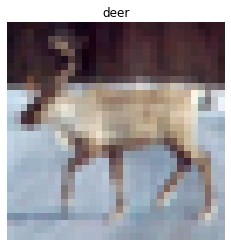

In [0]:
import matplotlib.pyplot as plt


def display(image, title):
    image = image.permute(1, 2, 0) # read about it
    image -= image.min()
    image /= image.max()
    plt.imshow(image.numpy())
    plt.axis('off')
    plt.title(title)
    plt.show()
    
# display the image
display(image, str(Class_of_the_image))

__2D Convolutions__

Say you want to learn a network to classify the images into the 10 classes. It will output a vector of probabilities of size 10 for each image of size `3 x 32 x 32`. First let's consider a simple fully-connected network.

In [0]:
import torch.nn as nn


class FullyConnectedNetwork(nn.Module):
    
    def __init__(self):
        super(FullyConnectedNetwork, self).__init__()
        self.fc1 = nn.Linear(3*32*32, 3*32*32)
        self.fc2 = nn.Linear(3*32*32, 10)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x
    

fully_connected = FullyConnectedNetwork()

In [0]:
fully_connected

FullyConnectedNetwork(
  (fc1): Linear(in_features=3072, out_features=3072, bias=True)
  (fc2): Linear(in_features=3072, out_features=10, bias=True)
)

What are the two main disadvantages of using a single fully-connected linear layer (squared) followed by a classifier?
 
First disadvantage: a fully connected layer will take a lot of parameters! Can you compute the size of the network?

#### Because Fully connected layers have too many parameters, which is very expensive to train 

In [0]:
# compute number of parameters
sum([p.nelement() for p in fully_connected.parameters()])

9470986

Second disadvantage: the fully connected layer does not take the structure of the image into account. Nearby pixels are highly correlated. 

That's why we will use convolutions.In the next illustration, we consider a 2D convolution.
- The blue image is called the _input_ image
- The green image is called the _output_ image 
- The convolutional filter has a size `3x3` that is called the _kernel size_

Here, convolutions are performed by successively considering areas of size `3x3` and applying the kernel to it. Applying the kernel consists in summing the element-wise product of the kernel and the input image area to get a single output number.

In [0]:
from IPython.display import HTML
HTML('<img src="https://miro.medium.com/max/790/1*1okwhewf5KCtIPaFib4XaA.gif">')

Let's consider a very simple kernel. Can you compute by hand the result of the convolution of the kernel by the input matrix? What is the size of the resulting output matrix?

In [0]:
import torch.nn.functional as F


kernel = torch.Tensor([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]])

input_matrix = torch.Tensor([
    [0, 0, 0, 1, 0],
    [0, 1, 0, 1, 0],
    [0, 0, 2, 1, 0],
    [0, 0, 0, 0, 3],
    [0, 0, 0, 1, 0],
])

print('Kernel')
print(kernel)
print('Input matrix')
print(input_matrix)
print('Output matrix')
print(F.conv2d(input_matrix.unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0)))

Kernel
tensor([[1., 2., 1.],
        [2., 4., 2.],
        [1., 2., 1.]])
Input matrix
tensor([[0., 0., 0., 1., 0.],
        [0., 1., 0., 1., 0.],
        [0., 0., 2., 1., 0.],
        [0., 0., 0., 0., 3.],
        [0., 0., 0., 1., 0.]])
Output matrix
tensor([[[[ 6., 10., 10.],
          [ 6., 12., 13.],
          [ 2.,  6., 12.]]]])





Now let's add some padding! It consists in adding zeros at each border of the image. What is the result? What is the size of the resulting image?

In [0]:
kernel = torch.Tensor([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]])

input_matrix = torch.Tensor([
    [0, 0, 0, 1, 0],
    [0, 1, 0, 1, 0],
    [0, 0, 2, 1, 0],
    [0, 0, 0, 0, 3],
    [0, 0, 0, 1, 0],
])

print('Kernel')
print(kernel)
print('Input matrix')
print(input_matrix)
print('Padded input matrix')
print(F.pad(input_matrix, (1, 1, 1, 1))) # read about it
print('Output matrix')
print(F.conv2d(input_matrix.unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0), padding=(1,1)))

Kernel
tensor([[1., 2., 1.],
        [2., 4., 2.],
        [1., 2., 1.]])
Input matrix
tensor([[0., 0., 0., 1., 0.],
        [0., 1., 0., 1., 0.],
        [0., 0., 2., 1., 0.],
        [0., 0., 0., 0., 3.],
        [0., 0., 0., 1., 0.]])
Padded input matrix
tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 2., 1., 0., 0.],
        [0., 0., 0., 0., 0., 3., 0.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.]])
Output matrix
tensor([[[[ 1.,  2.,  4.,  6.,  3.],
          [ 2.,  6., 10., 10.,  4.],
          [ 1.,  6., 12., 13.,  9.],
          [ 0.,  2.,  6., 12., 14.],
          [ 0.,  0.,  2.,  7.,  8.]]]])


Convolutions can help in a lot of ways! Let's consider three particular kernels and apply it on an image. Can you write the code to do it? What is the effect? What is the first kernel doing? The second one? Why? Can you change the second kernel to get the vertical edges? What os the mystery kernel doing?

In [0]:
import torch.nn.functional as F
def apply_conv(image, kernel):

    return F.conv2d(torch.Tensor(image).unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0)).squeeze().numpy()

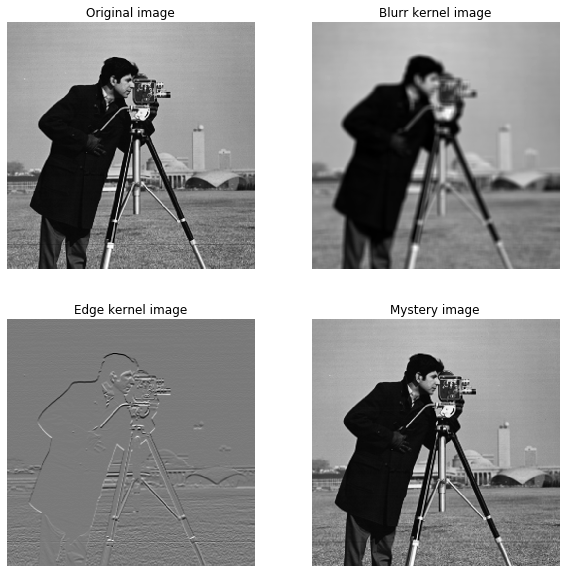

In [0]:
from skimage import data, img_as_float


blurr_kernel =  1 / 100 * torch.ones(10, 10)
edge_kernel =  torch.Tensor([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]])
mystery_kernel = torch.Tensor([
    [0, 0, 0],
    [1, 0, 0],
    [0, 0, 0]
])

input_image = img_as_float(data.camera())

blurr_image = apply_conv(input_image, blurr_kernel)
edge_image = apply_conv(input_image, edge_kernel)
mystery_image = apply_conv(input_image, mystery_kernel)

plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow(input_image, cmap='gray')
plt.title('Original image')
plt.axis('off')

plt.subplot(222)
plt.imshow(blurr_image, cmap='gray')
plt.title('Blurr kernel image')
plt.axis('off')

plt.subplot(223)
plt.imshow(edge_image, cmap='gray')
plt.title('Edge kernel image')
plt.axis('off')

plt.subplot(224)
plt.imshow(mystery_image, cmap='gray')
plt.title('Mystery image')
plt.axis('off')

plt.show()

__3D convolutions__

3D convolutions work exactly the same as 2D convolutions, except that the convolutions operate on 3D tensors (like images) with 3D filters. 

<font color=blue>Important conventions of notation</font>:
- Image of size `C_in x H x W` (input channels x height x width)
- `C_out` (output channels) filters of size `C_in x k x k` (input channels x kernel size x kernel size)

In [0]:
from IPython.display import HTML
HTML('<img src="https://predictiveprogrammer.com/wp-content/uploads/2018/06/convolve.gif">')

Question: with a kernel size of `k = 3` and a padding of `1`, if the input has size `C_in x H x W` and the filters have size `C_out x C_in x k x k`,  what is the size of the output?

It is `C_out x H x W`.

Define your own network
---

So far, we've understood how convolutions work and got a sense of their effectiveness (both in terms of parameters and ability to compute seemingly difficult operations such as detecting the edges). Now let's build a network!

The structure of the network is:

- Convolutional layer with 3 input filters, 32 output filters, kernel of size 5x5
- ReLU
- Convolutional layer with 32 input filters, 32 output filters, kernel of size 3x3
- ReLU
- Max pooling with kernel size 2x2
- Convolutional layer with 32 input filters, 64 output filters, kernel of size 3x3
- ReLU
- Convolutional layer with 64 input filters, 64 boutput filters, kernel of size 3x3
- ReLU
- Max pooling with kernel size 2x2
- Classifier of size ?? x 10 (you have to find the first dimension)


MaxPooling is taking the max along a receptive field of size `k x k` (see PyTorch documentation). To handle properly the Conv2d, see also PyTorch documentation. Print the sizes at each step, this will help you! Use `F.relu` for the ReLU!

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleNet(nn.Module):
    
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32,32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.pool1 = nn.MaxPool2d(3)
        self.pool2 = nn.MaxPool2d(3)
        self.fc = nn.Linear(64, 10)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.bn4(x)
        x = self.pool2(x)
        x = x.view(-1, 64) # why are we doing a x.view()  flatten the all conv into 1d 
        x = self.fc(x)
        
        return x
    
net = SimpleNet()
print(net)

SimpleNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=64, out_features=10, bias=True)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


Can you forward an image to the network? What does it output? How many parameters does the network have? How does it compare with the parameters of the fully connected architecture decribed below? 

In [0]:
image1 = image.unsqueeze(0) #  show onley one image 
image.shape, image1.shape

(torch.Size([3, 32, 32]), torch.Size([1, 3, 32, 32]))

In [0]:
device = 'cuda:0'
image1 = image.unsqueeze(0) 
out = net.forward(image1)
print(out)

# print number of parameters and compare it with the fully connected network!
sum([p.nelement() for p in fully_connected.parameters()])


tensor([[ 1.0330, -0.1865, -0.0068,  1.7599,  0.5797, -0.2621, -1.3426,  2.3530,
          0.1895, -0.1584]], grad_fn=<AddmmBackward>)


9470986

Train your own network
---

One single pass over the whole training set is called an _epoch_. An epoch consists in iterations, each iteration corresponds to the pass of one single batch.

In [0]:
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [0]:
net = SimpleNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)

device = 'cuda:0'
train1 = []
test1 = []
# loop over the dataset multiple times
for epoch in range(15):
    print('Epoch: {}'.format(epoch))
    
    # train for 1 epoch on the train set
    correct = 0
    for i, (batch, targets) in enumerate(trainloader):
        
        # batch and targets to cuda 
        batch, targets = batch.to(device), targets.to(device)
        # zero the parameter gradients
        optimizer.zero_grad() 
        # forward 
        outputs = net(batch)
        loss = criterion(outputs, targets)
        # backward
        loss.backward()
        # gradient step 
        optimizer.step()
        # compute accuracy 
        correct += accuracy(outputs, targets)[0].item() * batch.size(0) / 100

    top_1 = correct / len(trainloader.dataset) * 100 # why multiply by 100 we get accuracy 100 and that doesnot correct
    train1.append(top_1)
    print('Train accuracy: {:.2f}%'.format(top_1))
            
    # evaluate on the test set  
    with torch.no_grad():
        correct = 0
        for i, (batch, targets) in enumerate(testloader):

            # batch and targets to cuda 
            batch, targets = batch.to(device), targets.to(device)
            # forward 
            outputs = net(batch)
            # compute accuracy 
            correct += accuracy(outputs, targets)[0].item() * batch.size(0) / 100
     
    top_1 = correct / len(testloader.dataset) * 100
    test1.append(top_1)
    print('Test accuracy: {:.2f}%'.format(top_1))


Epoch: 0
Train accuracy: 48.97%
Test accuracy: 58.81%
Epoch: 1
Train accuracy: 62.48%
Test accuracy: 63.62%
Epoch: 2
Train accuracy: 67.56%
Test accuracy: 67.38%
Epoch: 3
Train accuracy: 70.61%
Test accuracy: 67.28%
Epoch: 4
Train accuracy: 73.10%
Test accuracy: 68.82%
Epoch: 5
Train accuracy: 74.69%
Test accuracy: 69.78%
Epoch: 6
Train accuracy: 76.29%
Test accuracy: 70.02%
Epoch: 7
Train accuracy: 77.46%
Test accuracy: 69.91%
Epoch: 8
Train accuracy: 78.51%
Test accuracy: 69.92%
Epoch: 9
Train accuracy: 79.83%
Test accuracy: 70.29%
Epoch: 10
Train accuracy: 80.59%
Test accuracy: 69.78%
Epoch: 11
Train accuracy: 81.36%
Test accuracy: 69.39%
Epoch: 12
Train accuracy: 81.93%
Test accuracy: 70.21%
Epoch: 13
Train accuracy: 82.27%
Test accuracy: 70.28%
Epoch: 14
Train accuracy: 83.14%
Test accuracy: 69.85%


In [0]:
test1

[58.809999999999995,
 63.62,
 67.38,
 67.28,
 68.82000000000001,
 69.78,
 70.02000000000001,
 69.91000000000001,
 69.92,
 70.28999999999999,
 69.78,
 69.39,
 70.21,
 70.28,
 69.85]

In [0]:
train1

[48.974000000000004,
 62.482000000000006,
 67.56400000000001,
 70.612,
 73.104,
 74.694,
 76.286,
 77.46,
 78.51,
 79.828,
 80.58800000000001,
 81.356,
 81.93,
 82.272,
 83.14200000000001]

Can you display the probability vector given by the network for a particular image that is well classified? Misclassified? Run this cell many times to see different results and comment on them!

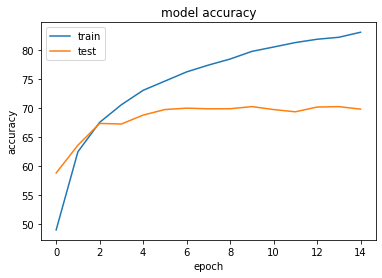

In [0]:
plt.plot(train1)
plt.plot(test1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
batch, targets = iter(trainloader).next()
image, target = batch[0], targets[0]
print('Size of the image: {}, class: {}\n'.format(image.size(), classes[target]))

outputs = net(image.to(device).unsqueeze(0))
probs = [float('{:.2f}'.format(p.item())) for p in F.softmax(outputs, dim=1).squeeze()]
print('Predicted classes with probabilities:')
print(dict(zip(classes, probs)))

Size of the image: torch.Size([3, 32, 32]), class: bird

Predicted classes with probabilities:
{'plane': 0.06, 'car': 0.0, 'bird': 0.29, 'cat': 0.59, 'deer': 0.01, 'dog': 0.03, 'frog': 0.01, 'horse': 0.0, 'ship': 0.01, 'truck': 0.0}


Improve the training of your own network
----

Neural networks are data hungry (think of a ResNet trained on the 1,200,000 images of ImageNet!). To simulate having more data without collecting it, we perform data augmentation:
- [RandomCrops](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomCrop)
- [RandomFlips](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.RandomHorizontalFlip)

See the PyTorch documentation for more detail!

In [0]:
transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
augmented_trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

Files already downloaded and verified


Train again the network!

In [0]:
net = SimpleNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)

device = 'cuda:0'
train2 = []
test2 = []
# loop over the dataset multiple times
for epoch in range(15):
    print('Epoch: {}'.format(epoch))
    
    # train for 1 epoch on the train set
    correct = 0
    for i, (batch, targets) in enumerate(augmented_trainloader):
        
        # batch and targets to cuda 
        batch, targets = batch.to(device), targets.to(device)
        # zero the parameter gradients
        optimizer.zero_grad() 
        # forward 
        outputs = net(batch)
        loss = criterion(outputs, targets)
        # backward
        loss.backward()
        # gradient step 
        optimizer.step()
        # compute accuracy 
        correct += accuracy(outputs, targets)[0].item() * batch.size(0) / 100
    #if epoch == 10:
      #optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)
    top_1 = correct / len(trainloader.dataset) * 100
    train2.append( top_1)
    print('Train accuracy: {:.2f}%'.format(top_1))
            
    # evaluate on the test set  
    with torch.no_grad():
        correct = 0
        for i, (batch, targets) in enumerate(testloader):

            # batch and targets to cuda 
            batch, targets = batch.to(device), targets.to(device)
            # forward 
            outputs = net(batch)
            # compute accuracy 
            correct += accuracy(outputs, targets)[0].item() * batch.size(0) / 100
     
    top_1 = correct / len(testloader.dataset) * 100
    test2.append( top_1)
    print('Test accuracy: {:.2f}%'.format(top_1))


Epoch: 0
Train accuracy: 49.26%
Test accuracy: 56.89%
Epoch: 1
Train accuracy: 61.55%
Test accuracy: 62.90%
Epoch: 2
Train accuracy: 66.56%
Test accuracy: 66.82%
Epoch: 3
Train accuracy: 69.73%
Test accuracy: 68.92%
Epoch: 4
Train accuracy: 71.79%
Test accuracy: 69.35%
Epoch: 5
Train accuracy: 73.10%
Test accuracy: 69.38%
Epoch: 6
Train accuracy: 74.36%
Test accuracy: 70.80%
Epoch: 7
Train accuracy: 75.14%
Test accuracy: 72.16%
Epoch: 8
Train accuracy: 76.11%
Test accuracy: 71.71%
Epoch: 9
Train accuracy: 76.92%
Test accuracy: 72.46%
Epoch: 10
Train accuracy: 77.38%
Test accuracy: 72.58%
Epoch: 11
Train accuracy: 77.85%
Test accuracy: 72.93%
Epoch: 12
Train accuracy: 78.39%
Test accuracy: 72.46%
Epoch: 13
Train accuracy: 79.02%
Test accuracy: 73.55%
Epoch: 14
Train accuracy: 79.11%
Test accuracy: 72.93%


In [0]:
test2, train2

([57.46,
  64.37,
  66.61,
  68.35,
  69.42,
  69.96,
  71.31,
  71.56,
  72.18,
  72.39999999999999,
  72.65,
  74.55000000000001,
  75.1,
  74.74,
  75.03],
 [49.118,
  61.67399999999999,
  66.716,
  69.506,
  71.596,
  72.98599999999999,
  74.278,
  75.076,
  76.248,
  76.484,
  77.658,
  81.022,
  82.068,
  82.69999999999999,
  82.952])

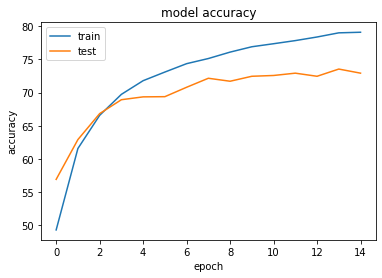

In [0]:
plt.plot(train2)
plt.plot(test2)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

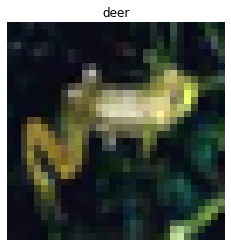

In [0]:
batch, targets = iter(augmented_trainloader).next() # read about itr and next
image, target = batch[0], targets[0]
# display the image
display(image, str(Class_of_the_image))

Hyperparameter search
----

Can we try to get a better performance when:
- Adding more layers to the network 
- Tuning the learning rate 
- Training during more epochs 
- Adding BatchNorm layers after the convolution layers to normalize the activaitons
- Divide the learning rate by 10 after 10 epochs 

In [0]:
# when we find the shape of len(trainloader.dataset) and len(agumented.dataset) we get the same shape 50000 after doing randomcrops and randomflips (we increacing the number of images but doing it iternal and get the same shape to saving the memory)